<a href="https://colab.research.google.com/github/alejandromaranon/FEM/blob/main/FEM_1D_barra_006b_termico_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejemplo 6: Barra FEM 1D con Efecto Térmico - Formulación Global**

La barra sólidamente unida a los soportes superior e inferior, está sometida al efecto de su propio peso y al de una carga $P$ localizada a $L_p$ del soporte inferior. La barra tiene una longitud $L$, un área de sección transversal $A$, una densidad $\rho$, un módulo de elasticidad $E$ y un coeficiente de expansión térmica $α$ La barra experimenta un cambio de temperatura $\Delta T$.

In [22]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/alejandromaranon/FEM/9dce073baeaa8e08ba6393f3502a83f55f1dcec8/Images/FEM_1D_barra_006c_termico_global.svg', width=250)


En este ejemplo se implementa el Método de Elementos Finitos (**formulación global**), para el cálculo de desplazamientos y esfuerzos en la barra.

## Forma fuerte (desplazamientos) del problema

Dados $A$, $\rho$, $E$, $α$ y $\Delta T$ en $[0,L]$ encontrar $u$ tal que:

$EA u_{1,xx} + \rho g A = 0$ en $[0,L-L_p]$

$u_1=0$ en $x=0$

$EA u_{2,xx} + \rho g A = 0$ en $[L-L_p,L]$

$u_2=0$ en $x=L$

$u_1=u_2$ en $x=L-L_p$

$u_{1,x} = u_{2,x}+P/AE$ en $x=L-L_p$

Las soluciones exactas del desplazamiento y del esfuerzo de esta forma son las siguientes:

$u_1(x) = \frac{\rho g}{2E}(Lx-x^2)+(\frac{Lp}{L})\frac{Px}{AE}$ en $[0,L-L_p]$

$u_2(x) = \frac{\rho g}{2E}(L^2-x^2)+(x-L)(\frac{\rho g L}{2E}-\frac{P(L-L_p)}{AEL})$ en $[L_p,L]$


$σ_1(x) = \rho g (\frac{L}{2}-x)+(\frac{Lp}{L})\frac{P}{A}-E \alpha ΔT$ en $[0,L-L_p]$

$σ_2(x) = \rho g (\frac{L}{2}-x)+\frac{P(L-Lp)}{AL}-E \alpha ΔT$ en $[L_p,L]$

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import beta

**NOTA IMPORTANTE**:

En Python el primer indice (posición) de un arreglo (vector o matriz) es cero (0). A diferencia de Matlab, donde el primer indice es 1.


## Pre-procesamiento
Durante el preprocesamiento, se genera la malla para una geometría determinada y se especifican las propiedades de los materiales, las condiciones de frontera y las cargas prescritas.

In [24]:
# ----
# Parámetros de control del problema
# ----

# Geometría de la barra [SI]
L = 1.5             # Longitud en [m]
A = 0.01          # Area de la sección transversal [m^2]

# Propiedades mecánicas del material
E = 200E9         # Módulo de Elasticidad [Pa]

# Propiedades físicas del material
alfa = 12E-6      # Coeficiente de expansión térmica [1/C]
ro = 7850         # Densidad [kg/m^3]

# Propiedades del ambiente
g = 9.81       # Aceleración del a gravedad [m/s^2]
dT = 50           # Cambio de temperatura [C]

# Carga en la barra
P = 200           # Carga puntual[N]
Lp = L/3          # Localización de la barra desde el extremo inferior [m]

# Discretización de elementos finitos
nel_T = 1       # Número de elementos (número inicial tRentativo)


In [25]:
# ----
# Coordenadas (localización) de cada uno de los nodos
# (en este ejemplo se distribuiran los nel elementos entre los
# segmentos superior e inferior a la localización de la barra)
# ----

xp = (L-Lp)
div_sup = int(np.ceil((1-(Lp/L))*nel_T))
div_inf = int(np.ceil((Lp/L)*nel_T))

x_sup = np.linspace(0,(L-Lp), div_sup, False)
x_inf = np.linspace((L-Lp), L, div_inf+1)
x_coord = np.concatenate((x_sup, x_inf))

nel = div_sup + div_inf   # Número de elementos

nnodos = nel + 1          # Número de nodos (nel + 1)

# print(x_coord)

In [26]:
# ----
# Arreglo de conectividad nodal de cada elemento
# (Topología de los elementos)
# ----

# Dado que en un problema 1D la numeración de los nodos
# es secuencial, se utiliza un arreglo bi-dimensional
# en el cual el primer indice indica el numero del elemento
# y el segundo o indice denota el número del nodo asociado con
# dicho elemento. La primera columna es el nodo 1 de la
# fomulación local y la segunda columna el nodo 2.

nodos = np.array([[i,i+1] for i in range(nel)], dtype=int)

# print(nodos)

In [27]:
# ----
# Tamaño de los elementos (longitud entre nodos)
# ----

he = np.zeros((nel, 1))

for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # extrae las coordenadas de los nodos
  x1 = x_coord[nodo1]
  x2 = x_coord[nodo2]

  # calcula la longitud del elemento
  he[num_ele] = (x2-x1)

# print(he)

In [28]:
# ----
# Condiciones de frontera
# (Desplazamientos conocidos)
# ----

# La primera columna de cf es el número del nodo y
# el segundo es el valor del desplazamiento en dicho nodo.

cf = np.array([[0, 0], [nnodos-1, 0]])  # Recordar que los indices inician en cero.

# print(cf)

In [29]:
# ----
# Fuerzas nodales aplicadas
# ----

fn = np.array([[(div_sup), P]])

# print(fn)

## Solución
Durante la solución, se calculan las matrices de elementos y se resuelven las ecuaciones.

In [30]:
# ----
# Construcción de la matríx de rígidez K
# ----

K = np.zeros((nnodos, nnodos))

for i in range(nnodos):
    # Calcula la matriz triangular superior y luego aplica simetría
    for j in range(i, nnodos):
        if i == j:
            if i == 0:
                K[i, j] = E*A/he[j,0]
            elif i == nnodos - 1:
                K[i, j] = E*A/he[j-1,0]
            else:
                K[i, j] = E*A*(1/he[j-1,0]+1/he[j,0])
        elif abs(i - j) == 1:
            K[i, j] = -E*A/he[j-1,0]
            K[j, i] = K[i, j] # Simetría de la matriz de rigidez

# print(K)

In [31]:
# ----
# Construcción del vector de fuerza F
# ----

Ft = np.zeros((nnodos, 1))    # Componente del vector debido a los efectos térmicos
Fg = np.zeros((nnodos, 1))    # Componente del vector debido al peso.
F = np.zeros((nnodos, 1))     # F = Fg + Ft

for i in range(nnodos):
  if (i == 0):
    Ft[i] = -E*A*alfa*dT
    Fg[i] = ro*g*A*(he[i])/2
  elif (i == nnodos - 1):
    Ft[i] = E*A*alfa*dT
    Fg[i] = ro*g*A*(he[i-1])/2
  else:
    Ft[i] = 0
    Fg[i] = ro*g*A*(he[i-1] + he[i])/2

  F[i] = Ft[i]+Fg[i]

# ----
# Se incluyen en F las fuerzas nodales aplicadas (fn)
# ----

for num_fn in range(fn.shape[0]):
  i = fn[num_fn,0]      # este es el número del nodo
  F[i] += fn[num_fn,1]   # se suma el valor de la fuerza en el nodo

# print(F)

In [32]:
# ----
# Aplica las restricciones (desplazamientos conocidos)
# modificando K y F
# ----

# Se utiliza una copia de K para incluir las condiciones de frontera cf
Kcf = np.copy(K)

for num_cf in range(cf.shape[0]):
  i = cf[num_cf,0]      # este es el número del nodo
  F[i] = cf[num_cf,1]   # este es el valor del desplazamiento

  for j in range(nnodos):
    if i==j:
      Kcf[i,j] = 1
    else:
      Kcf[i,j] = 0

# print(Kcf,F)

In [33]:
# ----
# Cálculo de desplazamientos nodales
# ----

u = np.linalg.solve(Kcf,F)

# print(u)

In [34]:
# ----
# Calculo de reacciones nodales
# ----

Rn = K@u

# print(Rn)

In [35]:
# ----
# Calculo de esfuerzos en los elementos
# ----

esfuerzo =[]

for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # calcula la longitud del elemento
  esfuerzo.append(E*((-u[nodo1]+u[nodo2])/he[num_ele] - alfa*dT))

# print(esfuerzo)

## Post-procesamiento
Esta etapa se utiliza para visualizar las soluciones y ver imágenes gráficas de los desplazamientos, esfuerzos, deformaciones, etc.

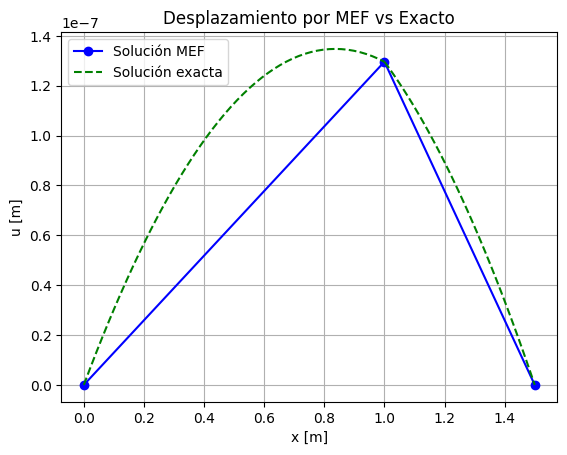

In [36]:
# ----
# Grafica de desplazamientos
# ----

# Deplazamientos del MEF
plt.plot(x_coord, u, 'b', marker = 'o', label='Solución MEF')
plt.xlabel('x')
plt.ylabel('Desplazamiento')
plt.title('Desplazamiento por MEF vs Exacto')

# Desplazamientos exactos

# Función u_sup(x) en el segmento superior
def u_sup(x):
    return ro*g*(L*x-x**2)/(2*E)+P*Lp*x/(A*E*L)

# Función u_inf(x) en el segmento inferior
def u_inf(x):
    return ro*g*(L**2-x**2)/(2*E)+(x-L)*(ro*g*L/(2*E)-P*(L-Lp)/(A*E*L))

x_s = np.linspace(0,(L-Lp))
u_s = u_sup(x_s)

x_i = np.linspace((L-Lp), L)
u_i = u_inf(x_i)


# Plot de solución exacta
plt.plot(x_s, u_s, 'g--', label='Solución exacta')
plt.plot(x_i, u_i, 'g--')

# Titulos de ejes
plt.xlabel('x [m]')
plt.ylabel('u [m]')
plt.legend()
plt.grid(True)


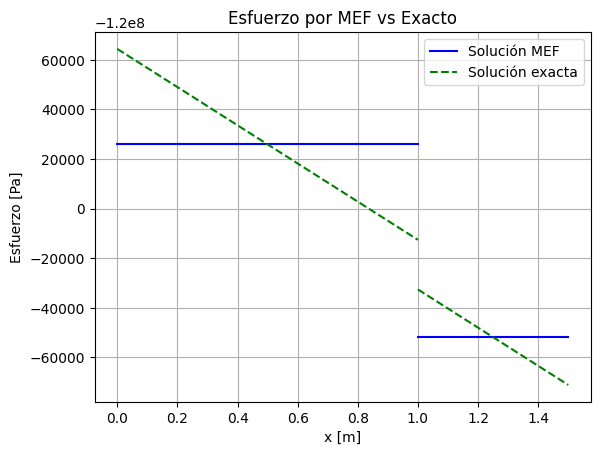

In [37]:
# ----
# Grafica de esfuerzos
# ----

# Esfuerzos del MEF
for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # extrae las coordenadas de los nodos
  x1 = x_coord[nodo1]
  x2 = x_coord[nodo2]

  plt.plot([x1,x2], [esfuerzo[num_ele][0], esfuerzo[num_ele][0]],'b')

# Esta línea es para que aparezca la etiqueta 'Solución MEF'
plt.plot([],[], 'b', label = 'Solución MEF')

# Formatea los nombres del eje de esfuerzo en notación de ingeniería
# plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Esfuerzos exactos

# Función esf_sup(x) en el segmento superior
def esf_sup(x):
    return ro*g*(L-2*x)/2+P*Lp/(A*L)-E*alfa*dT

# Función esf_inf(x) en el segmento inferior
def esf_inf(x):
    return ro*g*(L-2*x)/2-P*(L-Lp)/(A*L)-E*alfa*dT

x_s = np.linspace(0,(L-Lp),5)
esf_s = esf_sup(x_s)

x_i = np.linspace((L-Lp), L,5)
esf_i = esf_inf(x_i)

# Plot de solución exacta
plt.plot(x_s, esf_s, 'g--', label='Solución exacta')
plt.plot(x_i, esf_i, 'g--')
plt.legend(loc='best')

plt.xlabel('x [m]')
plt.ylabel('Esfuerzo [Pa]')
plt.title('Esfuerzo por MEF vs Exacto')
plt.grid(True)

plt.show()

In [38]:
# ----
# Reporte de parámetros para análisis de convergencia
# ----

# Esfuerzo en x = 0 (FEM)
print(((esfuerzo[0])))


[[-1.19974081e+08]]


## FIN

In [39]:
# prompt: Stop execution

# import sys
# sys.exit()
